# k-Means

Clustering algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points.

Many clustering algorithms are available in Scikit-Learn and elsewhere, but perhaps the simplest to understand is an algorithm known as *k-means clustering*, which is implemented in ``sklearn.cluster.KMeans``.

We begin with the standard imports:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

## Introducing k-Means

The *k*-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset.
It accomplishes this using a simple conception of what the optimal clustering looks like:

- The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
- Each point is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the *k*-means model.
We will soon dive into exactly *how* the algorithm reaches this solution, but for now let's take a look at a simple dataset and see the *k*-means result.

First, let's generate a two-dimensional dataset containing four distinct blobs.
To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization

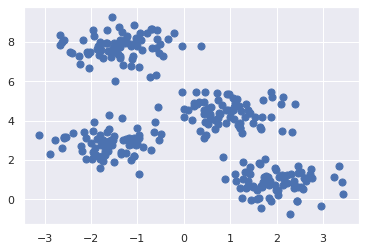

In [ ]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

By eye, it is relatively easy to pick out the four clusters.
The *k*-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Let's visualize the results by plotting the data colored by these labels.
We will also plot the cluster centers as determined by the *k*-means estimator:

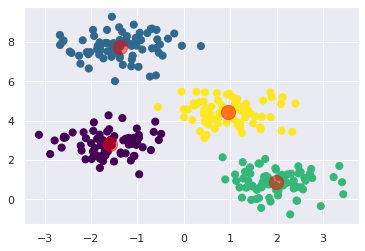

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);

The good news is that the *k*-means algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye.
But you might wonder how this algorithm finds these clusters so quickly! After all, the number of possible combinations of cluster assignments is exponential in the number of data points—an exhaustive search would be very, very costly.
Fortunately for us, such an exhaustive search is not necessary: instead, the typical approach to *k*-means involves an intuitive iterative approach known as *expectation–maximization*. 

## k-Means Algorithm: Expectation–Maximization

Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science.
*k*-means is a particularly simple and easy-to-understand application of the algorithm, and we will walk through it briefly here.
In short, the expectation–maximization approach here consists of the following procedure:

1. Guess some cluster centers
2. Repeat until converged
   1. *E-Step*: assign points to the nearest cluster center
   2. *M-Step*: set the cluster centers to the mean 

Here the "E-step" or "Expectation step" is so-named because it involves updating our expectation of which cluster each point belongs to.
The "M-step" or "Maximization step" is so-named because it involves maximizing some fitness function that defines the location of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

The literature about this algorithm is vast, but can be summarized as follows: under typical circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics.

The *k*-Means algorithm is simple enough that we can write it in a few lines of code. The following is a very basic implementation:

In [ ]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2, plot_step_centroids=False):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    iter = 1
    
    while True:
        # plot centroids
        if plot_step_centroids:
            print()
            plt.figure()
            plt.suptitle("Iteration {}".format(iter), fontsize=20)
            plt.scatter(X[:, 0], X[:, 1], s=50, cmap='viridis');
            plt.scatter(centers[:, 0], centers[:, 1], marker="o", c="red", s=200, edgecolor="k")

        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers        
        iter = iter+1
    
    return centers, labels


We can visualize the algorithm as shown in the following figure. For the particular initialization shown here, the clusters converge appropriately.

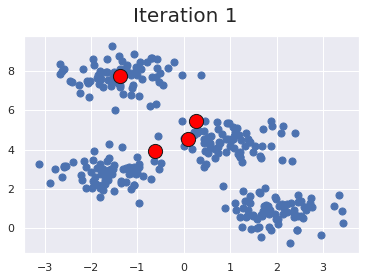

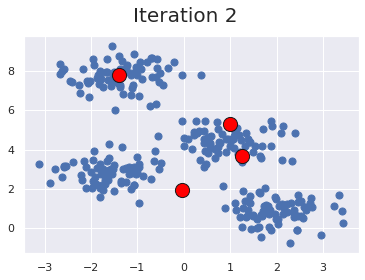

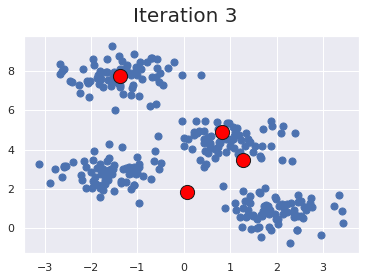

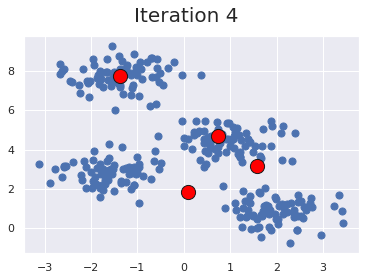

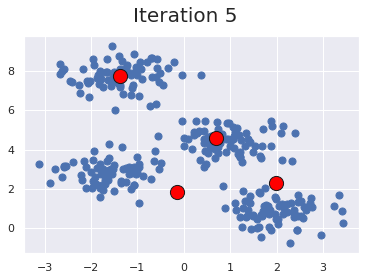

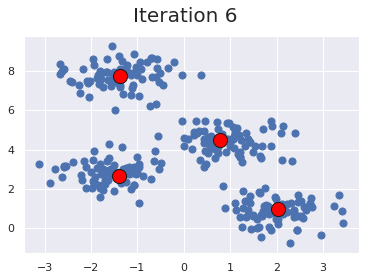

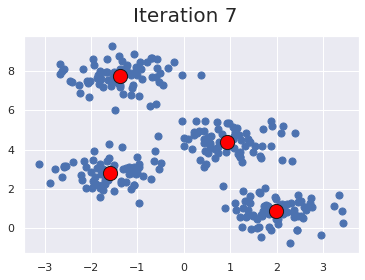

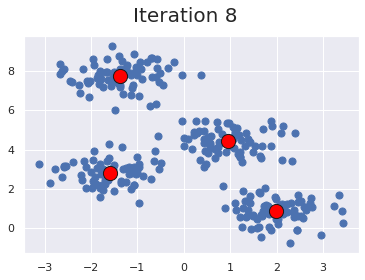

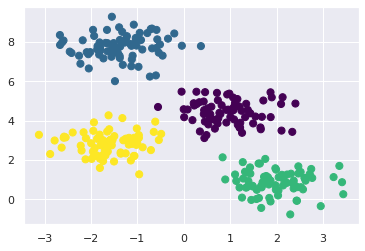

In [ ]:
centers, labels = find_clusters(X, 4, plot_step_centroids=True)
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Most well-tested implementations will do a bit more than this under the hood, but the preceding function gives the gist of the expectation–maximization approach.

### Caveats of expectation–maximization

There are a few issues to be aware of when using the expectation–maximization algorithm.

#### The globally optimal result may not be achieved
First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the *global* best solution.
For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results:

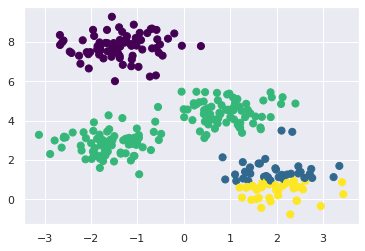

In [ ]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Here the E–M approach has converged, but has not converged to a globally optimal configuration. For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (set by the ``n_init`` parameter, which defaults to 10).

#### The number of clusters must be selected beforehand
Another common challenge with *k*-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data.
For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters:

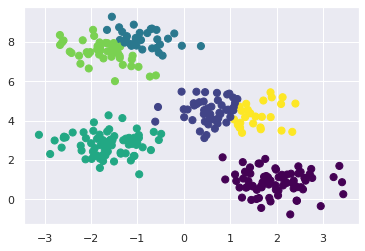

In [ ]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Whether the result is meaningful is a question that is difficult to answer definitively; one approach that is rather intuitive, but that we won't discuss further here, is called [silhouette analysis](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

Alternatively, you might use a more complicated clustering algorithm which has a better quantitative measure of the fitness per number of clusters (e.g., Gaussian mixture models; see [In Depth: Gaussian Mixture Models](05.12-Gaussian-Mixtures.ipynb)) or which *can* choose a suitable number of clusters (e.g., DBSCAN, mean-shift, or affinity propagation, all available in the ``sklearn.cluster`` submodule)

#### k-means is limited to linear cluster boundaries
The fundamental model assumptions of *k*-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

In particular, the boundaries between *k*-means clusters will always be linear, which means that it will fail for more complicated boundaries.
Consider the following data, along with the cluster labels found by the typical *k*-means approach:

In [ ]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

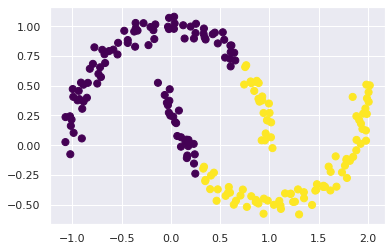

In [ ]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

#### k-means can be slow for large numbers of samples
Because each iteration of *k*-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows.
You might wonder if this requirement to use all data at each iteration can be relaxed; for example, you might just use a subset of the data to update the cluster centers at each step.



## Examples

Being careful about these limitations of the algorithm, we can use *k*-means to our advantage in a wide variety of situations.
We'll now take a look at an example.

### Iris dataset

The iris dataset is perhaps the best known database to be found in the pattern recognition literature. The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant. One class is linearly separable from the other 2; the latter are NOT linearly separable from each other.
Attribute Information:
1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm
5. class:
*   Iris Setosa
*   Iris Versicolour
*   Iris Virginica

https://archive.ics.uci.edu/ml/datasets/iris

https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data



Humans intuitively perceive data in two-dimensional and three-dimensional spaces, and the 4-dimensional representation of iris data belongs to high dimensional data. When clustering high-dimensional data, the complete object clustering will definitely increase the running cost of clustering algorithm. In addition, not all features are beneficial to clustering, and those that are irrelevant or redundant will make the class structure more blurred.

Let's show the distribution of the data according to Sepal length and width:

Text(0, 0.5, 'Sepal width')

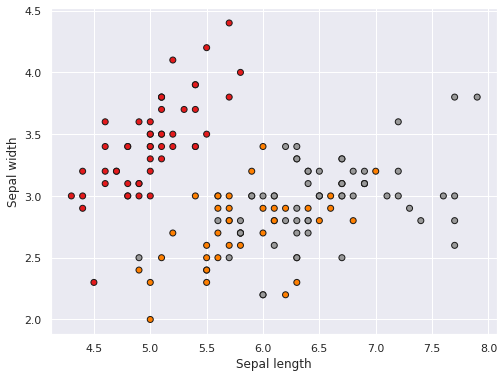

In [ ]:
import matplotlib.pyplot as plt
from sklearn import datasets

iris = datasets.load_iris()
x = iris.data
y = iris.target

# show the distribution of the data by using Sepal length and width
plt.figure(2, figsize=(8, 6))
plt.clf()
plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k") # we select the first two features (Sepal length and Sepal width)
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")




###Data preprocessing

Normalizing data previously is recommended when values are measured on different scales. Normalization means adjusting values measured on different scales to a notionally common scale.
One possibility is to use StandardScaler to help you standardize the dataset’s features onto unit scale (mean = 0 and variance = 1).

Text(0, 0.5, 'Sepal width')

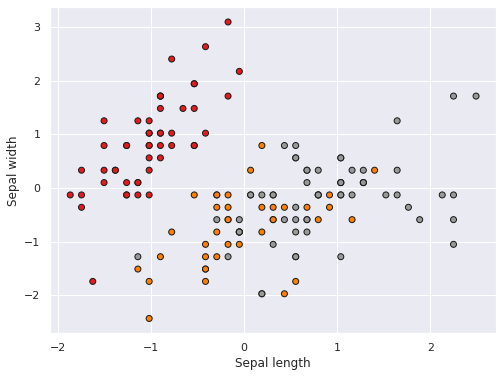

In [ ]:
from sklearn.preprocessing import StandardScaler
x_scaled = StandardScaler().fit_transform(x)

# show the distribution of the scaled data by using Sepal length and width
plt.figure(2, figsize=(8, 6))
plt.clf()
plt.scatter(x_scaled[:, 0], x_scaled[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

As shown, the distribution is the same but the values are different.

There are several possibilities for normalization. Another one is to compute as follows:

\begin{align}
X_{norm} = \frac{X - X_{min}}{X_{max}-X_{min}}
\end{align}

where $X_{max}$ and $X_{min}$ represent the maximum and minimum values of the set where $X$ is located, and the calculation result is to change the number into the decimal number between $[0, 1]$, which is convenient for subsequent clustering.

## Dimension-reduced processing
Now let's show the distribution of the data according to Sepal and Petal length:

Text(0, 0.5, 'Petal length')

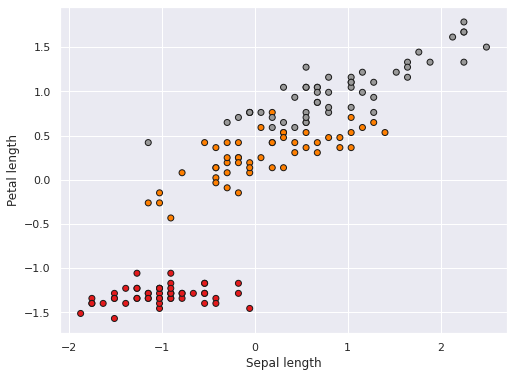

In [ ]:

# show the distribution of the scaled data by using Sepal and Petal length
plt.figure(2, figsize=(8, 6))
plt.clf()
plt.scatter(x_scaled[:, 0], x_scaled[:, 2], c=y, cmap=plt.cm.Set1, edgecolor="k") # we select features 0 and 2 (Sepal length and Petal length)
plt.xlabel("Sepal length")
plt.ylabel("Petal length")

As shown, the attribute pair {Sepal length, Petal length} seems more suitable than the pair {Sepal length, Sepal width} to cluster the data. 

The Principal Component Analysis (PCA) algorithm makes the data express the most features with fewer dimensions by transforming the coordinate space. The purpose of dimension reduction is to retain some important features and remove noise and unimportant features, so as to improve the data processing
speed and reduce the computational complexity and analysis difficulty in the process of analyzing high-dimensional data.

For example, we can project the data which is 4 dimensional into 2 dimensions:

Text(0, 0.5, 'Second principal component')

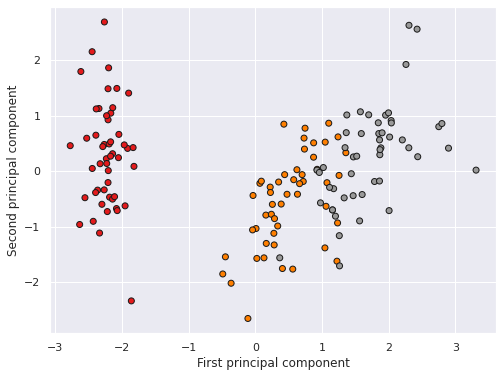

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x_scaled_pca = pca.fit_transform(x_scaled)

# show the distribution of the scaled data after the PCA
plt.figure(2, figsize=(8, 6))
plt.clf()
plt.scatter(x_scaled_pca[:, 0], x_scaled_pca[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")



The explained variance tells you how much information: (variance) can be attributed to each of the principal components. This is important as while you can convert 4 dimensional space to 2 dimensional space, you lose some of the variance (information) when you do this. 

In [ ]:
pca.explained_variance_ratio_
print(f'The first principal component contains {pca.explained_variance_ratio_[0]*100:.2f}% of the variance (information)')
print(f'The second principal component contains {pca.explained_variance_ratio_[1]*100:.2f}% of the variance')
print(f'Together, the two components contain {(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])*100:.2f}% of the variance')

The first principal component contains 72.96% of the variance (information)
The second principal component contains 22.85% of the variance
Together, the two components contain 95.81% of the variance


Instead of providing the number of principal components, it is better to let PCA choose the minimum number of principal components such a certain percentage of the variance is retained.

In [ ]:
pca = PCA(0.95) # 95% of the variance is retained
x_scaled_pca = pca.fit_transform(x_scaled)

## Data clustering analysis

Now we are going to group the data into different clusters. The clustering process aims to identify the different classes that belong to the dataset.

Text(0, 0.5, 'Second principal component')

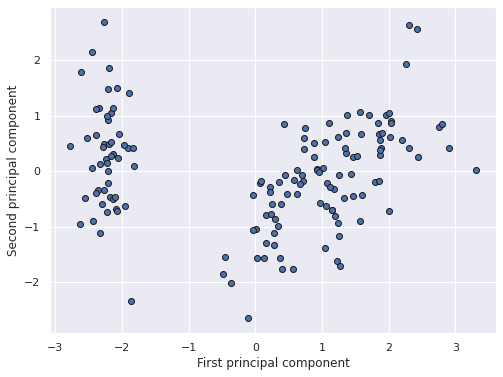

In [ ]:
# show the distribution of the scaled data after the PCA
plt.figure(2, figsize=(8, 6))
plt.clf()
plt.scatter(x_scaled_pca[:, 0], x_scaled_pca[:, 1], edgecolor="k")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

As shown, in a visual way, two cluster are very clear. Let's compute the k-means algorithm with different values of $k$.

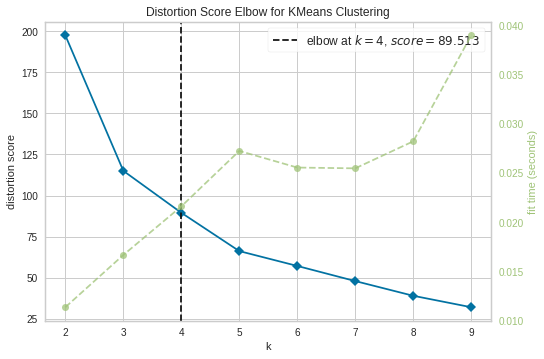

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10)) # a range of k values from 2 to 9

visualizer.fit(x_scaled_pca)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

The "elbow" method helps to select the optimal number of clusters by fitting the model with a range of values for $k$. If the line chart resembles an arm, then the "elbow" (the point of inflection on the curve) is a good indication that the underlying model fits best at that point. In the visualizer “elbow” will be annotated with a dashed black line.

The *KElbowVisualizer* displays the amount of time to train the clustering model per $k$ as a dashed orange line, but is can be hidden by setting *timings=False*.

Distortion computes the sum of squared distances from each point to its ssigned center. 

Two other metrics can also be used with the *KElbowVisualizer*: silhouette and calinski_harabasz. The silhouette score calculates the mean Silhouette Coefficient of all samples (mean ratio of intra-cluster and nearest-cluster distance). Suppose $a$ represents the average distance of a point from the other points of the cluster to which the point is assigned, and $b$ represents the minimum of the average distances of the point from the points of the other clusters. Now the silhouette width $s$ of the point is defined as:

\begin{align}
s = \frac{b - a}{max\{a,b\}}
\end{align}

Silhouette index $s(C)$ is the average Silhouette width of all the data points and it reflects the compactness and separation of clusters. The value of Silhouette index varies from -1 to 1 and higher values indicates better clustering results.

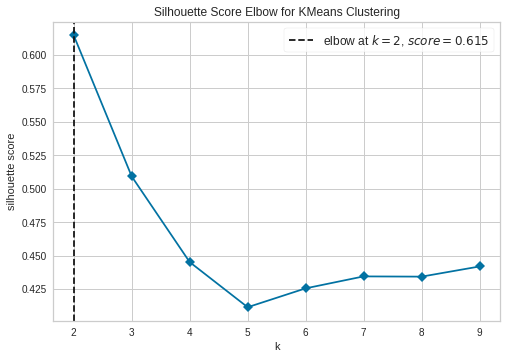

In [ ]:
visualizer = KElbowVisualizer(model, metric='silhouette', timings=False, k=(2,10)) # a range of k values from 2 to 9
visualizer.fit(x_scaled_pca)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

The Elbow method with silhouette metric indicates that $k=2$ is the optimal value of $k$. Now we can run the k-Means algorithm with $k=2$ to group the data and find the centroids.

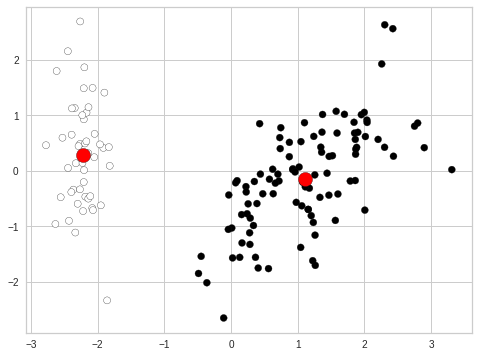

In [ ]:
clusterer = KMeans(n_clusters=2)
cluster_labels = clusterer.fit_predict(x_scaled_pca)
# show the actual clusters formed and centroids
plt.figure(2, figsize=(8, 6))
plt.clf()
plt.scatter(x_scaled_pca[:, 0], x_scaled_pca[:, 1], c=clusterer.labels_, edgecolor="k")
# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw red circles at cluster centers
plt.scatter(centers[:, 0], centers[:, 1], marker="o", c="red", s=200, edgecolor="k")